UNET ARCHITECTURE

In [29]:
import cv2
import os
#splits the image in to smaller images of size 512x512
def crop_image(image_path, output_dir):
    img = cv2.imread(image_path)

    # Get image dimensions
    height, width = img.shape[:2]

    if min(height, width) < 512:
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)

    # Calculate the number of rows and columns needed
    rows = height // 512
    cols = width // 512

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    base_name = os.path.basename(image_path)[:-4]
    #print(base_name)
    iter = 0
    # Iterate over rows and columns
    for row in range(rows+1):
        for col in range(cols+1):
            # Extract sub-image
            y1 = row * 512 
            if (y1+512)>= height:
                y1 = height%512
            y2 = y1+512
            x1 = col * 512 
            if (x1+512)>=width:
                x1 =  width%512
            x2 = x1+512 
            sub_img = img[y1:y2, x1:x2]

            #print("(x1,y1,x2,y2)=",(x1,y1,x2,y2))
            # Save sub-image
            output_path = os.path.join(output_dir, f"{base_name}_{iter}.jpg")
            cv2.imwrite(output_path, sub_img)
            iter += 1
#THIS FUNCTION WAS ALREADY USED AND AFTER USE THE CODE BLOCK WAS DELETED


UNET ARCHITECTURE 

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [31]:
#Convolution block of UNET (conv(x)->norm(x)->relu(x))
class DoubleConvBlock(nn.Module):
    def __init__(self,dim_in,dim_out):
        super(DoubleConvBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(dim_in,dim_out,kernel_size=3,padding=1,stride=1,bias=True),
            nn.BatchNorm2d(dim_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out,dim_out,kernel_size=3,padding=1,stride=1,bias=True),
            nn.BatchNorm2d(dim_out),
            nn.ReLU(inplace=True),
        )

    def forward(self,x):
        return self.conv(x)

In [59]:
class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=6,features=[64,128,256,512]):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList() #upsampling list
        self.downs = nn.ModuleList() #downsampling list
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        #encoding
        for feature in features:
            self.downs.append(DoubleConvBlock(in_channels,feature))
            in_channels = feature
        
        #decoding
        for feature in features[::-1]:
            self.ups.append(
                nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2)
            )
            self.ups.append(DoubleConvBlock(feature*2,feature))

        self.bottleneck = DoubleConvBlock(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)

        
        skip_connections = skip_connections[::-1]

        for index in range(0,len(self.ups),2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x),dim=1)
            x = self.ups[index+1](concat_skip)

        return self.final_conv(x)

In [60]:
#tessting with one image
def test():
    x = Image.open("DATA1/TRAIN_IMAGE/image_1.jpg")
    x = transforms.ToTensor()(x)
    x = x.unsqueeze(0) 
    print(x.shape)
    model = UNET(in_channels=3,out_channels=6)
    model.eval()
    preds = model(x)
    print(x.shape)
    print(preds.shape)
    return preds

In [61]:
img = test()

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 6, 512, 512])


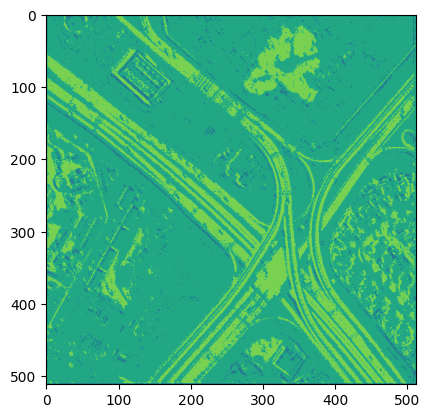

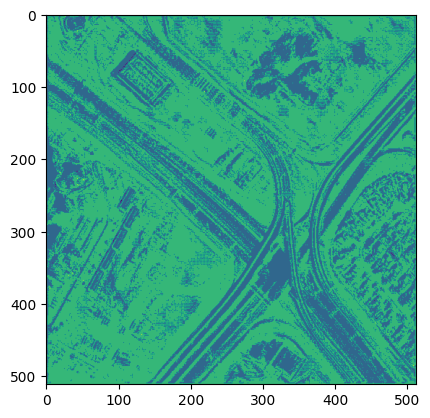

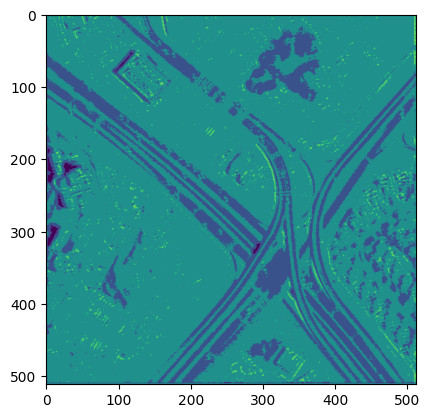

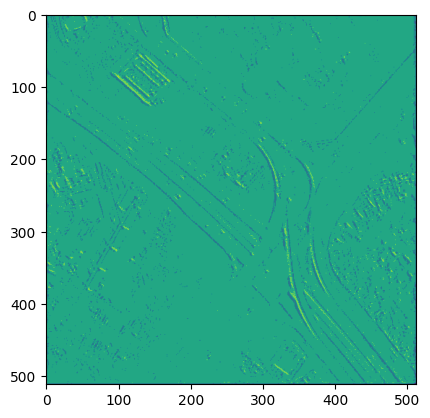

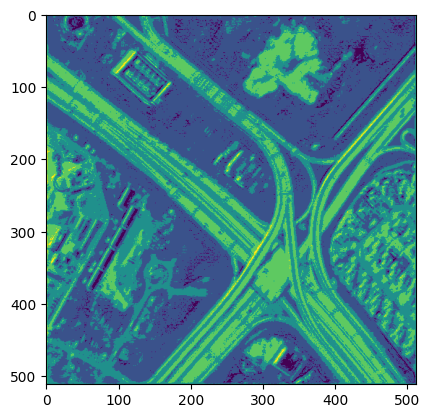

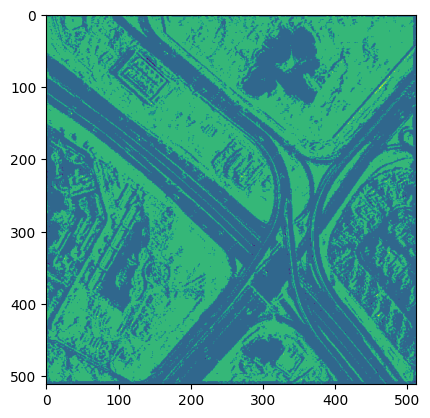

In [62]:
# Assuming you have the predicted tensor 'preds'
preds_np = img.detach().numpy().squeeze(0)  # Remove batch dimension

# Select the desired channel (e.g., channel 0 for the first class)
for channel_to_visualize in range(6):
    selected_channel = preds_np[channel_to_visualize]

    # Normalize if needed
    # selected_channel = (selected_channel * 255).astype(np.uint8)  # If values are in range [0, 1]

    # Convert to PIL Image
    image = transforms.ToPILImage()(selected_channel)

    # Display the image
    plt.imshow(image)
    plt.show()

In [63]:
with torch.no_grad():
    probabilities = F.softmax(img, dim=3)  # probabilities
    predicted_mask = torch.argmax(probabilities, dim=1).squeeze().cpu().numpy()  # class indices


colormap = {
    0: [60, 16, 152],   # Class 0: Water
    1: [110, 193, 228], # Class 1: Land (unpaved area)
    2: [132, 41, 246],  # Class 2: Road
    3: [155, 155, 155], # Class 3: Building
    4: [226, 169, 41],  # Class 4: Vegetation
    5: [254, 221, 58]   # Class 5: Unlabeled
}

predicted_mask

array([[5, 4, 4, ..., 2, 0, 1],
       [1, 4, 5, ..., 2, 2, 4],
       [1, 4, 2, ..., 2, 2, 1],
       ...,
       [5, 4, 4, ..., 2, 2, 2],
       [5, 4, 4, ..., 5, 2, 2],
       [5, 4, 4, ..., 5, 1, 1]], dtype=int64)

In [64]:
predicted_rgb_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.int64)
for class_index, color in colormap.items():
    predicted_rgb_mask[predicted_mask == class_index] = color

(-0.5, 511.5, 511.5, -0.5)

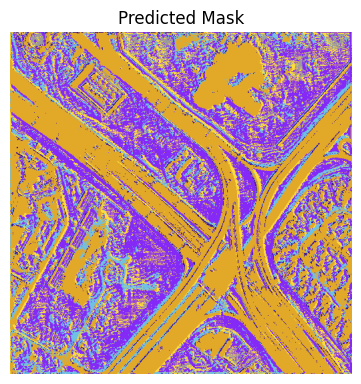

In [65]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Predicted Mask")
plt.imshow(predicted_rgb_mask)
plt.axis('off')

In [66]:
colormap = {
    0: [60, 16, 152],   # Class 0: Water
    1: [110, 193, 228], # Class 1: Land (unpaved area)
    2: [132, 41, 246],  # Class 2: Road
    3: [155, 155, 155], # Class 3: Building
    4: [226, 169, 41],  # Class 4: Vegetation
    5: [254, 221, 58]   # Class 5: Unlabeled
}
def label_rgb(image):
    label_indices = np.zeros((image.shape[0], image.shape[1]), dtype=np.int64)
    for i, cls in enumerate(colormap):
        label_indices[np.all(image == colormap[cls], axis=-1)] = cls

    # Convert to one-hot encoding if needed
    num_classes = len(colormap)
    label_indices = torch.nn.functional.one_hot(torch.from_numpy(label_indices), num_classes=num_classes)

    return label_indices

def convert_to_rgb(image):
    predicted_rgb_mask = np.zeros((image.shape[0],image.shape[1]),dtype=np.int64)
    for class_index, color in colormap.items():
        predicted_rgb_mask[predicted_mask == class_index] = color
    
    return predicted_rgb_mask

LOADING DATASET

In [67]:
'''class Dataset(nn.Module):
    def __init__(self,img_dir,mask_dir,num_classes=6,transform=None):
        self.image_dir = img_dir
        self.mask_dir = mask_dir
        self.num_classess = num_classes
        self.transform = transform
        self.images = self.load_images(self.images_dir)

    def load_images(self, directory):
        image_paths = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.jpg'):  # images are in '.jpg' format
                    image_paths.append(os.path.join(root, file))
        return image_paths
    
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_list[index])
        mask_path = os.path.join(self.mask_dir, self.image_list[index])

        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = label_rgb(mask)
        mask = torch.tensor(mask)
        return image, mask
'''

"class Dataset(nn.Module):\n    def __init__(self,img_dir,mask_dir,num_classes=6,transform=None):\n        self.image_dir = img_dir\n        self.mask_dir = mask_dir\n        self.num_classess = num_classes\n        self.transform = transform\n        self.images = self.load_images(self.images_dir)\n\n    def load_images(self, directory):\n        image_paths = []\n        for root, _, files in os.walk(directory):\n            for file in files:\n                if file.endswith('.jpg'):  # images are in '.jpg' format\n                    image_paths.append(os.path.join(root, file))\n        return image_paths\n    \n    def __len__(self):\n        return len(self.image_list)\n\n    def __getitem__(self, index):\n        image_path = os.path.join(self.image_dir, self.image_list[index])\n        mask_path = os.path.join(self.mask_dir, self.image_list[index])\n\n        image = Image.open(image_path).convert('RGB')  # Assuming RGB images\n        mask = Image.open(mask_path)\n\n        i

TRAINING

In [68]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
'''
train_image_dir = r"TRAIN_DATA\TRAIN_IMAGE"
train_mask_dir = r"TRAIN_DATA\TRAIN_MASK"  
test_image_dir = r"TEST_DATA\TEST_IMAGE"
test_mask_dir = r"TEST_DATA\TEST_MASK"

train_data = Dataset(train_image_dir,train_mask_dir,transform=transform)
test_data = Dataset(test_image_dir,test_mask_dir,transform=transform)'''

<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Admin\AppData\Local\Temp\ipykernel_20260\2774215975.py:5: SyntaxWarning: invalid escape sequence '\T'
  '''


'\ntrain_image_dir = r"TRAIN_DATA\\TRAIN_IMAGE"\ntrain_mask_dir = r"TRAIN_DATA\\TRAIN_MASK"  \ntest_image_dir = r"TEST_DATA\\TEST_IMAGE"\ntest_mask_dir = r"TEST_DATA\\TEST_MASK"\n\ntrain_data = Dataset(train_image_dir,train_mask_dir,transform=transform)\ntest_data = Dataset(test_image_dir,test_mask_dir,transform=transform)'

In [104]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, num_classes=6, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.num_classes = num_classes
        self.transform = transform

        # Load image and mask paths efficiently
        self.image_paths, self.mask_paths = self._load_images(image_dir, mask_dir)

    def _load_images(self, img_dir, mask_dir):
        print("inside _load_images")
        image_paths = []
        mask_paths = []
        #print(img_dir)
        #print(mask_dir)
        for root, _, files in os.walk(img_dir):
            #print(root)
            #print(_)
            for file in files:
                #print(file)
                if file.endswith('.jpg'):  # Adjust for your image format
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, os.path.basename(file)).replace("image","mask")  # Assuming same names and order
                    #print("mask_path inside load:",mask_path)
                    image_paths.append(image_path)
                    mask_paths.append(mask_path)
        return image_paths, mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        #print("inside __get_item__")
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path)  # Assuming RGB images
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        

        # Handle mask conversion (assuming color-coded segmentation masks)
        #print("mask.shape before transpose:",mask.shape)
        mask = np.array(mask).transpose(1, 2, 0)
        #print("mask.shape after transpose:",mask.shape)
        mask = label_rgb(mask)
        #print("mask.shape after label_rgb:",mask.shape)
        mask = torch.tensor(mask,dtype=torch.float64)
        #print("mask.shape after torch.tensor:",mask.shape)
        mask = mask.permute(2,0,1)
        #print("mask.shape after permute:",mask.shape)
        return image, mask

# Fix the escape sequences for raw strings (if necessary)
train_image_dir = r'DATA1\TRAIN_IMAGE'
train_mask_dir = r'DATA1\TRAIN_MASK'
test_image_dir = r'DATA1\TEST_IMAGE'
test_mask_dir = r'DATA1\TEST_MASK'

# Create the datasets
train_data = MyDataset(train_image_dir, train_mask_dir, transform=transform)
test_data = MyDataset(test_image_dir, test_mask_dir, transform=transform)

train_loader = DataLoader(train_data,batch_size=17)
test_loader = DataLoader(test_data,batch_size=17)

inside _load_images
inside _load_images


In [105]:
#model parameter
n_channels = 3
n_classes = 6  
#optimzer parameter 
learning_rate = 0.0001
weight_decay = 0.003

device = "cpu" 
model = UNET(n_channels, n_classes).to(device)
criterion = nn.CrossEntropyLoss()  # used for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

#training parameter
max_epochs = 2

In [106]:
train_data.image_dir

'DATA1\\TRAIN_IMAGE'

In [107]:
# Training loop
for epoch in range(max_epochs):

    model.train()  # Set model to training mode
    train_loss = 0.0
    for images, masks in train_loader:
        print("running training loop")
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if masks.shape[1] != n_classes:  # If masks are not one-hot encoded
            masks = masks.long()  # Convert to long tensor for cross-entropy
        else:
            masks = masks.argmax(dim=1)
        loss = criterion(outputs, masks.long())  # Convert masks to long tensor for cross-entropy
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            print("running validation loop")
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            #print("mask.shape:",masks.shape)
            #print("image.shape",images.shape)
            #print("output.shape",outputs.shape)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{max_epochs}, Val Loss: {val_loss:.4f}")

# Save the trained model (optional)
#torch.save(model.state_dict(), "model.pth")

C:\Users\Admin\AppData\Local\Temp\ipykernel_20260\2114241654.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask,dtype=torch.float64)


running training loop
Epoch 1/2, Train Loss: 1.8259
running validation loop
Epoch 1/2, Val Loss: 1.7071
running training loop
Epoch 2/2, Train Loss: 1.8068
running validation loop
Epoch 2/2, Val Loss: 1.6902


output shape: torch.Size([1, 6, 512, 512])
probabilities shape: torch.Size([1, 6, 512, 512])
predicted_mask shape: (512, 512)
ground_truth_mask shape: (512, 512, 3)
predicted_rgb_mask shape: (512, 512, 3)


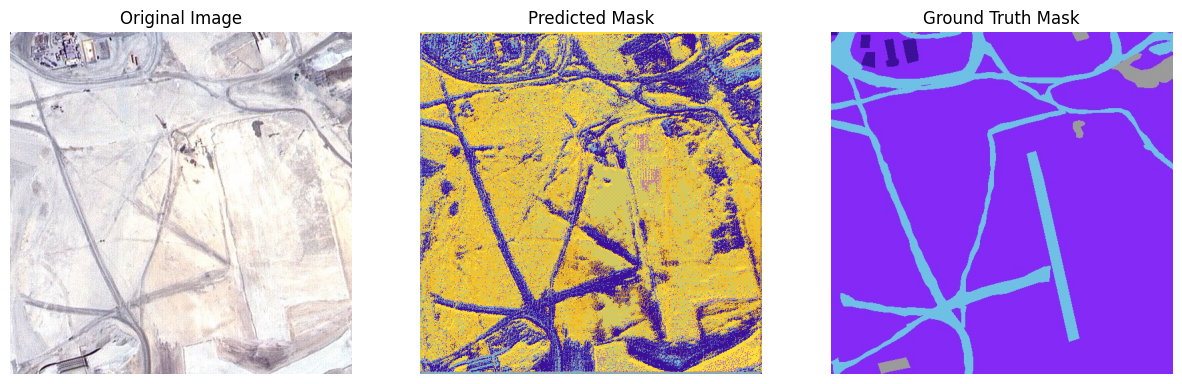

In [120]:
ground_truth_mask = np.array(Image.open("DATA1/TRAIN_MASK/mask_4.jpg"))
test_image_path = "DATA1/TRAIN_IMAGE/image_4.jpg"
original_image = Image.open(test_image_path)

transform = transforms.Compose([
    transforms.ToTensor()
])

image_tensor = transform(original_image).unsqueeze(0).to(device) # remove the batch dimention

model.eval()

with torch.no_grad():
    output = model(image_tensor)
    probabilities = F.softmax(output, dim=2)  # probabilities
    predicted_mask = torch.argmax(probabilities, dim=1).squeeze().cpu().numpy()  # class indices

print("output shape:",output.shape)
print("probabilities shape:",probabilities.shape)
print("predicted_mask shape:",predicted_mask.shape)
print("ground_truth_mask shape:",ground_truth_mask.shape)
colormap = {
    0: [60, 16, 152],   # Class 0: Water
    1: [110, 193, 228], # Class 1: Land (unpaved area)
    2: [132, 41, 246],  # Class 2: Road
    3: [155, 155, 155], # Class 3: Building
    4: [226, 169, 41],  # Class 4: Vegetation
    5: [254, 221, 58]   # Class 5: Unlabeled
}

predicted_rgb_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.int64)
for class_index, color in colormap.items():
    predicted_rgb_mask[predicted_mask == class_index] = color

print("predicted_rgb_mask shape:",predicted_rgb_mask.shape)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_rgb_mask)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask)
plt.axis('off')

plt.show()

In [23]:
x = predicted_rgb_mask - ground_truth_mask

In [25]:
n = predicted_rgb_mask - x